## Importing Libraries

In [1]:
# Load the "autoreload" extension so that code can change.
%load_ext autoreload

# Always reload modules so that as you change code in src, it gets loaded.
%autoreload 2

In [2]:
%%time 
import os
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
plt.style.use("seaborn-darkgrid")

from urllib.request import urlopen
warnings.filterwarnings('ignore')

# Set the option to display all columns without truncation
pd.set_option('display.max_columns', None)

<timed exec>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


CPU times: total: 2.03 s
Wall time: 2.9 s


In [3]:
# Output plots into notebook properly.
%matplotlib inline

## Load and Clean Dataset

In [4]:
def load_data():
    """
    Loads Airbnb listing data from a specified URL, removes duplicate listing IDs, and returns a DataFrame.

    Returns:
    DataFrame: A DataFrame with loaded Airbnb listing data, with no duplicate listing IDs.

    Raises:
    Exception: Raises an exception if there is an issue with loading or processing the data.
    """
    df = pd.DataFrame()
    try:
        url = "http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/data/listings.csv.gz"
        with urlopen(url) as resp:
            df_temp = pd.read_csv(resp, compression='gzip')

        # For records with the same id, keep the newer record
        df_temp['last_scraped'] = pd.to_datetime(df_temp['last_scraped'])
        df_temp = df_temp.sort_values(by='last_scraped', ascending=False).drop_duplicates('id')

        df = df_temp if not df_temp.empty else df
    except Exception as e:
        print(f"Error loading data: {str(e)}")

    return df

In [5]:
def clean_currency(x):
    """
    Cleans currency values in the given input.

    Parameters:
    - x: The input value, which can be a string or any other data type.

    Returns:
    str or other: If the input is a string, returns the string with dollar signs ('$') and commas (',') removed.
                  If the input is not a string, returns the input value unchanged.

    Example:
    clean_currency('$1,200.00')  # Returns '1200.00'
    clean_currency(1500)         # Returns 1500
    clean_currency(12.34)        # Returns 12.34
    clean_currency('Not a $ value')  # Returns 'Not a $ value'
    """
    if isinstance(x, str):
        return x.replace('$', '').replace(',', '')
    else:
        return x   

In [6]:
def clean_perc(x):
    """
    Cleans percentage values in the given input.

    Parameters:
    - x: The input value, which can be a string or any other data type.

    Returns:
    str or other: If the input is a string, returns the string with percentage signs ('%') removed.
                  If the input is not a string, returns the input value unchanged.

    Example:
    clean_perc('90%')   # Returns '90'
    clean_perc(75)       # Returns 75
    clean_perc(0.85)     # Returns 0.85
    clean_perc('Not a % value')  # Returns 'Not a % value'
    """
    if isinstance(x, str):
        return x.replace('%', '')
    else:
        return x   

In [7]:
def clean_data(df):
    """
    Cleans the input DataFrame by dropping unnecessary columns, adjusting data types, and transforming specific columns.

    Parameters:
    - df (DataFrame): The input DataFrame containing unprocessed data.

    Returns:
    DataFrame: A cleaned DataFrame with adjusted data types and dropped columns.

    Notes:
    - The input DataFrame is expected to have 74 columns.
    - The output DataFrame will have 82 columns, with boolean, percentage, currency, etc., in the correct data type.
    - The cleaning process includes:
        - Dropping columns identified in the 'drop_list' that are duplicate, empty, or meaningless.
        - Converting boolean columns ('host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable') to boolean type.
        - Converting the 'price' column from the form '$1,200.00' to a float.
        - Converting datetime columns ('last_scraped', 'first_review', 'last_review') from string form to datetime type.
        - Converting percentage columns ('host_response_rate', 'host_acceptance_rate') from the form '90%' to a float value (0.9).
        - Changing 'id' and 'host_id' columns to string type, as their numerical values are meaningless.
        - Removing single and double inverted commas and brackets from lists within a DataFrame column.

    Dependencies:
    - The functions 'clean_currency' and 'clean_perc' are assumed to be available for processing currency and percentage data.
    """
    # Define the columns that are no longer needed because they are duplicate, empty, or meaningless
    drop_list = [
        'calendar_last_scraped',
        'host_thumbnail_url',
        'host_picture_url',
        'listing_url',
        'maximum_maximum_nights',
        'maximum_minimum_nights',
        'maximum_nights_avg_ntm',
        'minimum_maximum_nights',
        'minimum_minimum_nights',
        'minimum_nights_avg_ntm',
        'neighbourhood_group_cleansed',
        'picture_url',
        'scrape_id',
    ]
    df_dropped = df.drop(labels = drop_list, axis = 1)
    
    # Define the columns that need to adjust data type
    cols_to_bool = [
        'has_availability',
        'host_has_profile_pic',
        'host_identity_verified',
        'host_is_superhost',
        'instant_bookable',
    ]
    cols_to_price = ['price']
    cols_to_datetime = [
        'first_review',
        'last_scraped', 
        'last_review',
    ]
    cols_to_perc = [
        'host_acceptance_rate',
        'host_response_rate',
    ]
    cols_to_str = [
        'id',
        'host_id',
    ]
    cols_list_to_str = [
        "amenities",
        "host_verifications",
    ]
    

    # change boolean values from 't' or 'f' to boolean type
    print(f"Converting below columns to bool: {cols_to_bool}")
    df_dropped[cols_to_bool] = (df_dropped[cols_to_bool] == 't')

    # change price from the form '$1,200.00' to a float 1200
    print(f"Cleaning currency data for the below columns: {cols_to_price}")
    for col in cols_to_price:
        df_dropped[col] = df_dropped[col].apply(clean_currency).astype('float')
    
    # change datetime from string form to datetime type
    print(f"Converting the listed Date columns to the Datetime format: {cols_to_datetime}")
    df_dropped[cols_to_datetime] = df_dropped[cols_to_datetime].apply(lambda x: pd.to_datetime(x))

    # change percentage data from form '90%' to float value 0.9
    print(f"Cleaning Percentage data for the below columns: {cols_to_perc}")
    for col in cols_to_perc:
        df_dropped[col] = df_dropped[col].apply(clean_perc).astype('float')/100

    # change id columns to string because their numerical values are meaningless
    print(f"Converting ID columns to strings for the below columns: {cols_to_str}")
    for col in cols_to_str:
        df_dropped[col] = df_dropped[col].astype(str)
    
    # Removing single and double inverted commas and brackets from lists within a DataFrame column.
    print(f"Cleaning list data for the below columns: {cols_list_to_str}")
    for col in cols_list_to_str:
        df_dropped[col] = (df_dropped[col].apply(
            lambda x: str(x).replace('[', '').replace(']', '').replace("'", '').replace('"', '')
        )
    )

    return df_dropped

In [8]:
def load_and_clean():
    """
    Loads data using the 'load_data' function and then cleans the data using the 'clean_data' function.

    Returns:
    DataFrame: A cleaned DataFrame after loading and processing the data.

    Note:
    - Ensure that the 'load_data' and 'clean_data' functions are defined and available in the current environment.
    - This function assumes that 'load_data' returns a DataFrame, and 'clean_data' takes a DataFrame as input and returns a cleaned DataFrame.
    """
    df = load_data()
    df_cleaned = clean_data(df)
    return df_cleaned

In [9]:
%%time
df_listing_cleaned = load_and_clean()
print(f"\nThe shape of the cleaned listing dataframe is {df_listing_cleaned.shape}")

Converting below columns to bool: ['has_availability', 'host_has_profile_pic', 'host_identity_verified', 'host_is_superhost', 'instant_bookable']
Cleaning currency data for the below columns: ['price']
Converting the listed Date columns to the Datetime format: ['first_review', 'last_scraped', 'last_review']
Cleaning Percentage data for the below columns: ['host_acceptance_rate', 'host_response_rate']
Converting ID columns to strings for the below columns: ['id', 'host_id']
Cleaning list data for the below columns: ['amenities', 'host_verifications']

The shape of the cleaned listing dataframe is (87946, 62)
CPU times: total: 5.03 s
Wall time: 30.5 s


In [10]:
df_listing_cleaned.head()

,id,last_scraped,source,name,description,neighborhood_overview,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
29470,30394669,2023-09-07,previous scrape,Rental unit in Greater London · 1 bedroom · 1 ...,NaN,NaN,130086045,https://www.airbnb.com/users/show/130086045,鏵萱,2017-05-13,"England, United Kingdom",NaN,NaN,NaN,NaN,False,NaN,1.0,1.0,"email, phone",True,True,NaN,Islington,51.53129,-0.11766,Private room in rental unit,Private room,1,NaN,1 shared bath,NaN,1.0,"Heating, Elevator, Hot water, Hair dryer, Wifi...",22.0,1,8,NaN,True,0,0,0,0,1,0,0,2018-12-23,2018-12-23,4.0,4.0,4.0,4.0,5.0,5.0,5.0,NaN,False,1,0,1,0,0.02
28718,29609515,2023-09-07,previous scrape,Rental unit in Greater London · ★5.0 · 2 bedro...,"Spacious flat in a secure, modern apartment bl...",NaN,7033600,https://www.airbnb.com/users/show/7033600,Raoul,2013-06-21,"England, United Kingdom",NaN,NaN,NaN,NaN,False,LB of Ealing,1.0,1.0,"email, phone",True,False,NaN,Ealing,51.51351,-0.31030,Entire rental unit,Entire home/apt,4,NaN,1 bath,2.0,2.0,"Heating, Elevator, Hair dryer, Washer, Wifi, S...",165.0,4,11,NaN,True,0,0,0,0,5,0,0,2018-12-25,2022-07-31,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,False,1,1,0,0,0.09
28698,29533491,2023-09-07,city scrape,Bed and breakfast in Greater London · 1 bedroo...,Light bright large king size bedroom in typica...,NaN,54250830,https://www.airbnb.com/users/show/54250830,Madeleine,2016-01-11,"London, United Kingdom",NaN,NaN,NaN,NaN,False,LB of Newham,2.0,6.0,"email, phone",True,False,NaN,Newham,51.54252,0.01477,Private room in bed and breakfast,Private room,1,NaN,1 shared bath,NaN,1.0,"Heating, Hot water, Iron, Carbon monoxide alar...",200.0,5,15,NaN,True,23,53,83,83,1,0,0,2019-03-08,2019-03-08,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2,0,2,0,0.02
28699,29602591,2023-09-07,previous scrape,Rental unit in Erith · 2 bedrooms · 3 beds · 2...,This is a spacious two bedroom ground floor ap...,NaN,222822037,https://www.airbnb.com/users/show/222822037,Robert,2018-10-27,"England, United Kingdom","Single man in his forties, quiet and caring",NaN,NaN,NaN,False,NaN,1.0,2.0,"email, phone, work_email",True,False,NaN,Bexley,51.47495,0.18040,Entire rental unit,Entire home/apt,5,NaN,2 baths,2.0,3.0,"Heating, Elevator, Hot water, Iron, Carbon mon...",100.0,1,1125,NaN,True,0,0,0,0,0,0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1,1,0,0,NaN
28700,29533495,2023-09-07,previous scrape,Home in Greater London · 1 bedroom · 1 bed · 1...,Only Females!<br />Bright double room in a fri...,NaN,222382048,https://www.airbnb.com/users/show/222382048,Ez,2018-10-24,NaN,NaN,NaN,NaN,NaN,False,LB of Barnet,1.0,1.0,"email, phone",True,False,NaN,Barnet,51.59806,-0.24289,Private room in home,Private room,2,NaN,1 shared bath,NaN,1.0,"Heating, Hair dryer, Iron, Lock on bedroom doo...",30.0,1,15,NaN,False,0,0,0,0,0,0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1,0,1,0,NaN


In [11]:
df_listing_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87946 entries, 29470 to 87945
Data columns (total 62 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            87946 non-null  object        
 1   last_scraped                                  87946 non-null  datetime64[ns]
 2   source                                        87946 non-null  object        
 3   name                                          87946 non-null  object        
 4   description                                   86679 non-null  object        
 5   neighborhood_overview                         47190 non-null  object        
 6   host_id                                       87946 non-null  object        
 7   host_url                                      87946 non-null  object        
 8   host_name                                     87941 non-null  

In [12]:
# Brief Insight of df_listing_cleaned

insights_dict= {
    "Number of properties"  : len(df_listing_cleaned["id"]), 
    "Number of unique host" : len(df_listing_cleaned["host_name"].unique()),
    "Number of Room Type" : len(df_listing_cleaned["room_type"].unique()),
    "Number of Neighbourhood" : len(df_listing_cleaned["neighbourhood_cleansed"].unique()),
    "Average Price for all listings in London" : round(df_listing_cleaned["price"].mean(),2),
    "Maximum Price for all listings in London" : round(df_listing_cleaned["price"].max(),2),
    "Minimum Price for all listings in London" : round(df_listing_cleaned["price"].min(),2),
    "Number of 0 (Zero) Price in London" : len(df_listing_cleaned[df_listing_cleaned["price"]==0]),
    "Average Number of Reviews for all listing in London" : round(df_listing_cleaned["number_of_reviews"].mean(),2),
    
}
for name, code in insights_dict.items():
    print(f"{name} : {code}.")

Number of properties : 87946.
Number of unique host : 14977.
Number of Room Type : 4.
Number of Neighbourhood : 33.
Average Price for all listings in London : 181.35.
Maximum Price for all listings in London : 80100.0.
Minimum Price for all listings in London : 0.0.
Number of 0 (Zero) Price in London : 3.
Average Number of Reviews for all listing in London : 17.98.


## Analyzing Neighbourhood Cleansed

### Problem: Find the top 10 Neighbourhood Listings present in the London?

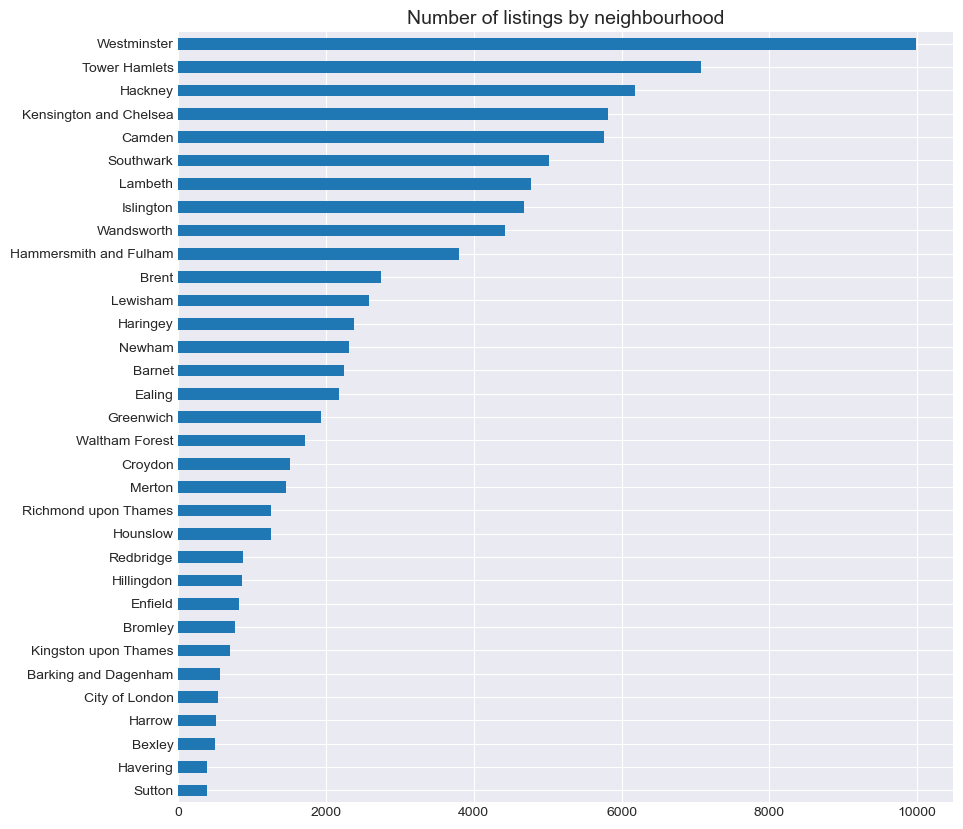

In [13]:
df_listing_cleaned['neighbourhood_cleansed'].value_counts().sort_values().plot.barh(figsize=(10, 10));
sns.despine()
plt.title('Number of listings by neighbourhood', fontsize=14);

In [14]:
print(f"The top 10 Neighbourhood Listings present in the London are listed below:")
df_listing_cleaned.groupby(by='neighbourhood_cleansed').count()[['id']].sort_values(by='id', ascending=False).head(10)

The top 10 Neighbourhood Listings present in the London are listed below:


,id
neighbourhood_cleansed,
Westminster,9992
Tower Hamlets,7080
Hackney,6182
Kensington and Chelsea,5818
Camden,5757
Southwark,5015
Lambeth,4774
Islington,4675
Wandsworth,4419


#### Westminster has the highest listing within the dataset with 9992 listings.

## Analyzing Property Type

### Problem: Determine the percentage of each property type.

The percentage of each property type is listed below: 


Entire rental unit             38.318968
Private room in rental unit    16.436222
Private room in home           12.142678
Entire condo                    9.887886
Entire home                     8.592773
                                 ...    
Shared room in earthen home     0.001137
Room in rental unit             0.001137
Minsu                           0.001137
Shipping container              0.001137
Tent                            0.001137
Name: property_type, Length: 102, dtype: float64

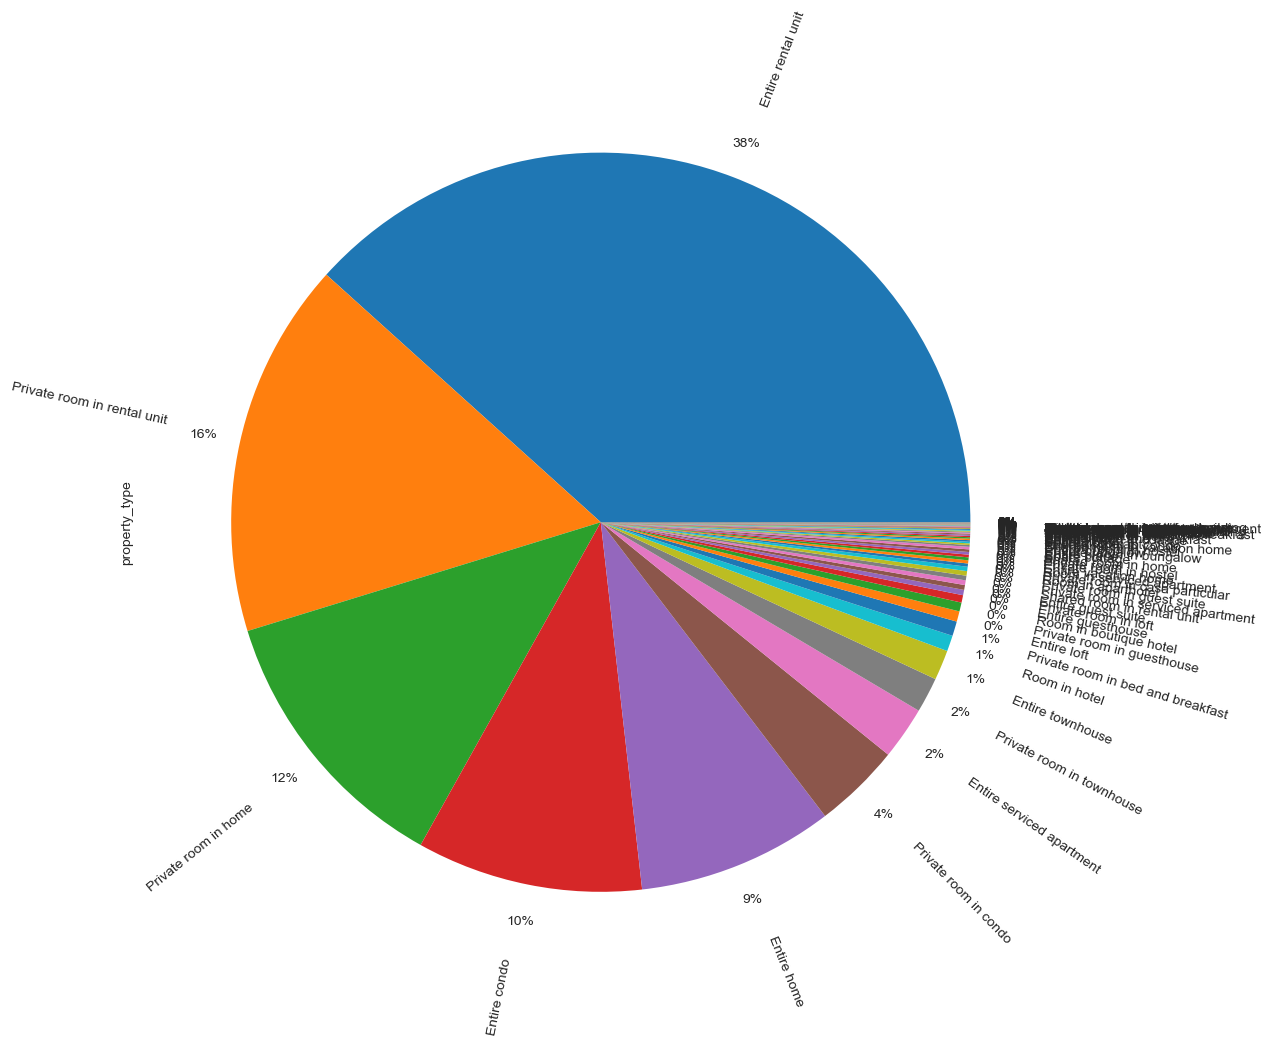

In [15]:
print(f"The percentage of each property type is listed below: ")
display(100*df_listing_cleaned['property_type'].value_counts(normalize=True))

# plot the pie chart of property categories
plt.figure(figsize = (20, 12))
df_listing_cleaned['property_type'].value_counts(normalize=True).plot.pie(autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, rotatelabels=True)
plt.show()

#### The data set has a large number of Entire rental unit, followed by Private room in rental unit and then by Private room in home  and Entire condo. Also, among the properties with very small percentage, we have 'Shared room in earthen home', 'Room in rental unit', 'Minsu', 'Shipping container' and 'Tent'.

## Analyzing Room Type

### Problem: Determine the most common room_type.

<Axes: xlabel='count', ylabel='room_type'>

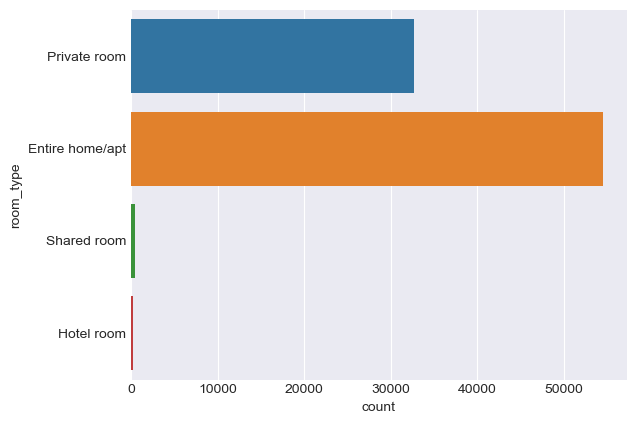

In [16]:
sns.countplot(y="room_type", data = df_listing_cleaned)

## Analyzing Amenities

### Problem: Determine the Most Common Amenities provided for the listings.

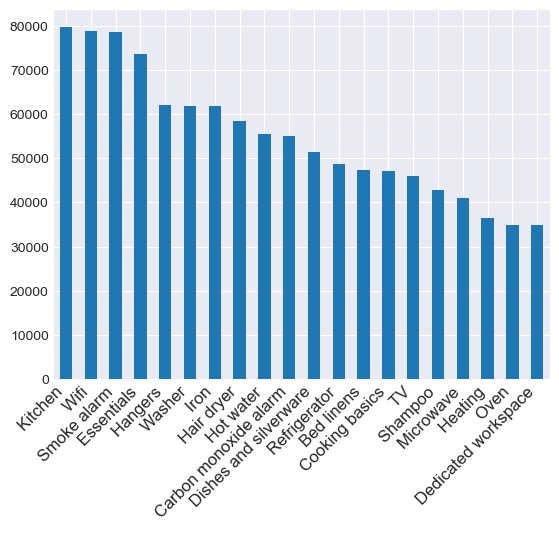

In [17]:
(pd.Series(
    np.concatenate(
        df_listing_cleaned['amenities'].map(lambda amns: amns.split(","))
    )
).value_counts()
 .head(20)
 .plot(kind='bar')
)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.show();

In [18]:
print(f"The top 5 most common amenities are listed below: ")
(pd.Series(
    np.concatenate(
        df_listing_cleaned['amenities'].map(lambda amns: amns.split(","))
    )
).value_counts()
 .head(5))

The top 5 most common amenities are listed below: 


 Kitchen        79679
 Wifi           78710
 Smoke alarm    78585
 Essentials     73504
 Hangers        62011
dtype: int64

#### Kitchen is the most common amenities listed with a count of almost 80000.

## Analyzing Review scores

### Problem: Demostrate the distribution of review scores, grouped by room type.

<Axes: title={'center': 'Review scores distribution for London Airbnb properties.'}, xlabel='room_type', ylabel='review_scores_rating'>

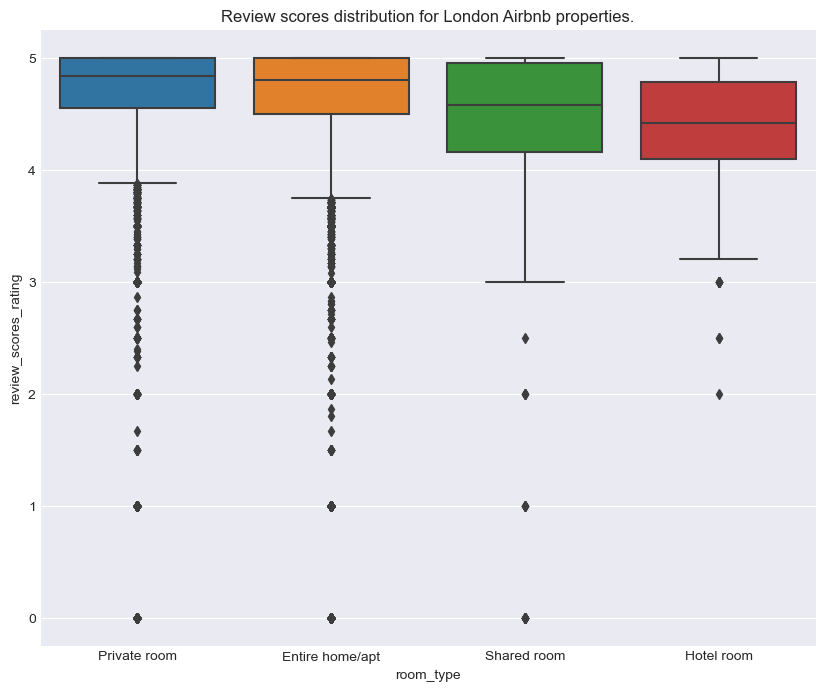

In [19]:
plt.figure(figsize=(10,8))
plt.title('Review scores distribution for London Airbnb properties.')
sns.boxplot(y='review_scores_rating', x='room_type', data = df_listing_cleaned[['room_type', 'review_scores_rating']])

## Analyzing hosts

### Problem: Determine the top host with Most listings.

In [20]:
# Which hosts (IDs) have the most listings
top_host = df_listing_cleaned.host_id.value_counts().head(10)
top_host_id = top_host.index[0]
top_host_listings = top_host.iat[0]

# Verifying the output with the already existing column called 'calculated_host_listings_count'
assert top_host_listings == df_listing_cleaned.calculated_host_listings_count.max()

print(f"The top host ID is {top_host_id} with {top_host_listings} listings.")

The top host ID is 129230780 with 595 listings.


[Text(0.5, 1.0, 'Hosts with Maximum Listings in London')]

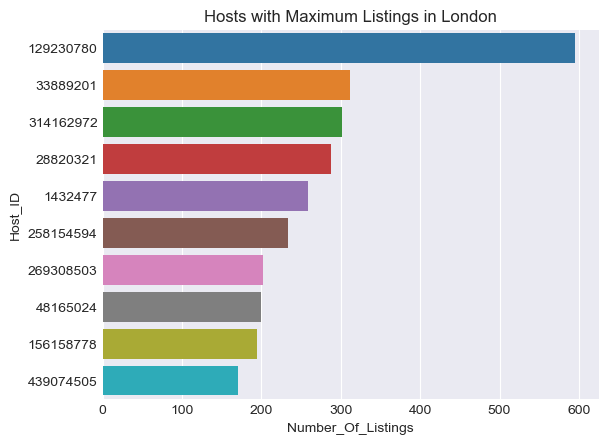

In [21]:
top_host_df = (pd.DataFrame(top_host)
               .reset_index()
               .rename(columns={'index':'Host_ID', 'host_id':'Number_Of_Listings'})
              )
# Create a bar plot
sns.barplot(y="Host_ID", x="Number_Of_Listings", data=top_host_df).set(title="Hosts with Maximum Listings in London")

#### Interesting, we can see that there is a good distribution between top 10 hosts with the most listings. The top host ID is 129230780 with 595 listings.

### Problem: Which hosts has the Highest Number of Listings in which area.

In [22]:
host_area = df_listing_cleaned.groupby(["host_name", "neighbourhood_cleansed"])['calculated_host_listings_count'].max().reset_index()
host_area = host_area.sort_values(by="calculated_host_listings_count", ascending=False).head(10)
host_area

,host_name,neighbourhood_cleansed,calculated_host_listings_count
29287,STK Homes,Ealing,595
29292,STK Homes,Hounslow,595
29288,STK Homes,Greenwich,595
29298,STK Homes,Westminster,595
29297,STK Homes,Tower Hamlets,595
29296,STK Homes,Southwark,595
29294,STK Homes,Lambeth,595
29293,STK Homes,Islington,595
29295,STK Homes,Newham,595
29291,STK Homes,Hillingdon,595


[Text(0.5, 0, 'Host Name'),
 Text(0, 0.5, 'Calculated Host Listing Count'),
 Text(0.5, 1.0, 'Host with Calculated Host Listing Count')]

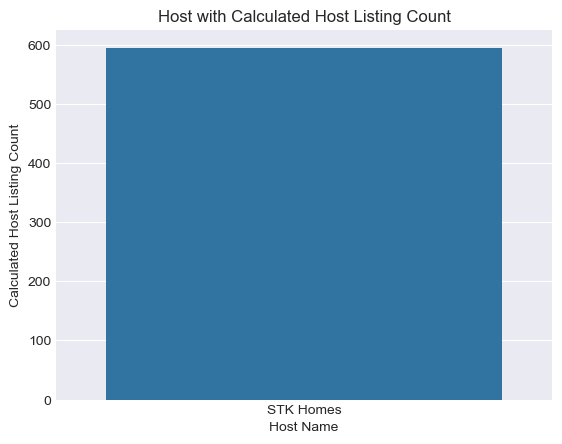

In [23]:
sns.barplot(x="host_name", y="calculated_host_listings_count", data=host_area).set(
    xlabel= "Host Name",
    ylabel = "Calculated Host Listing Count", 
    title= "Host with Calculated Host Listing Count"
)

### Problem: Which hosts are the busiest and why?

In [24]:
busiest_host = df_listing_cleaned.groupby(["host_name", "neighbourhood_cleansed", "room_type"])["minimum_nights"].count().reset_index()
busiest_host = busiest_host.sort_values(by="minimum_nights", ascending=False).head(5)
busiest_host

,host_name,neighbourhood_cleansed,room_type,minimum_nights
34790,STK Homes,Westminster,Entire home/apt,173
1772,Ali,Westminster,Entire home/apt,129
1506,Alex,Westminster,Entire home/apt,117
4394,Atanas,Westminster,Entire home/apt,106
10105,Dina,Camden,Private room,93


[Text(0.5, 0, 'Host Name'),
 Text(0, 0.5, 'Minimum Nights'),
 Text(0.5, 1.0, 'Busiest Hosts')]

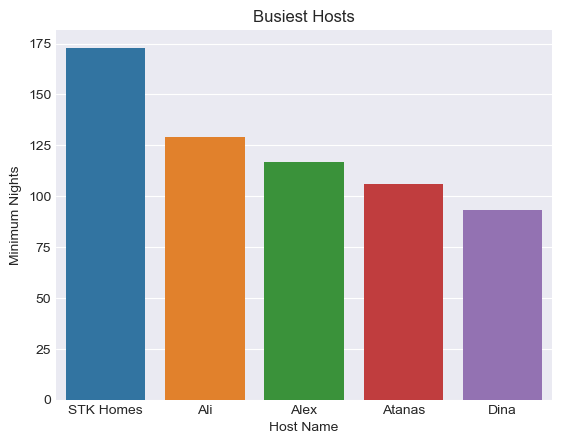

In [25]:
sns.barplot(x="host_name", y="minimum_nights", data=busiest_host).set(
    xlabel= "Host Name",
    ylabel = "Minimum Nights", 
    title= "Busiest Hosts"
)

#### STK Homes is the busiest host with the property listed for the highest minimum days.

## Analyzing Review Score Rating

### Problem: Determine the Maximum and the Average Review Score Rating

count    65788.000000
mean         4.596540
std          0.750778
min          0.000000
25%          4.500000
50%          4.820000
75%          5.000000
max          5.000000
Name: review_scores_rating, dtype: float64

<Figure size 1200x600 with 0 Axes>

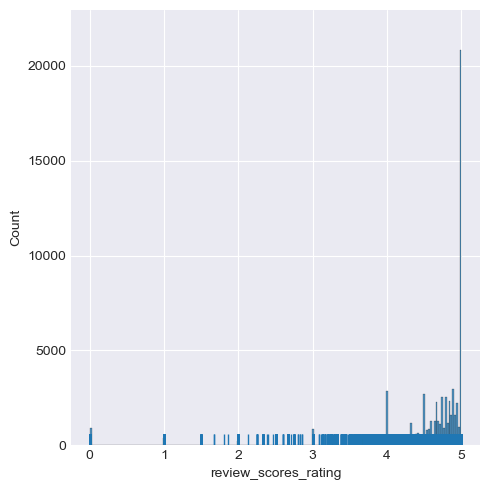

In [26]:
display(df_listing_cleaned.review_scores_rating.describe())

plt.figure(figsize=(12,6))
sns.displot(df_listing_cleaned.review_scores_rating.dropna(), rug=True)
sns.despine()
plt.show();

In [27]:
max_review_scores_rating = round(df_listing_cleaned.review_scores_rating.max(),2)
mean_review_scores_rating = round(df_listing_cleaned.review_scores_rating.mean(),3)
print(f"The maximum and mean of the review scores rating are {max_review_scores_rating} and {mean_review_scores_rating} resp.")

The maximum and mean of the review scores rating are 5.0 and 4.597 resp.


#### As expected, most of reviewers leave high scores.

## Analyzing Number of Reviews

### Problem: Determine the 10 most reviewed listings with Average Price per night in London

In [28]:
#let's grab 10 most reviewed listings in London
top_reviewed_listings=df_listing_cleaned.nlargest(10,'number_of_reviews')
top_reviewed_listings

,id,last_scraped,source,name,description,neighborhood_overview,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
29831,30760930,2023-09-06,city scrape,Boutique hotel in Bayswater · ★4.54 · 1 bedroo...,"Our finest product, the Double rooms with Gard...",Conveniently located to some of the most popul...,217727211,https://www.airbnb.com/users/show/217727211,London House,2018-09-28,"England, United Kingdom",NaN,within an hour,0.99,1.00,False,Bayswater,23.0,27.0,"email, phone",True,True,"Bayswater, London, United Kingdom",Westminster,51.51397,-0.18949,Room in boutique hotel,Private room,2,NaN,1 private bath,1.0,1.0,"Self check-in, Bathtub, Room-darkening shades,...",198.0,1,1125,NaN,True,16,44,74,198,1536,478,49,2019-01-28,2023-09-05,4.54,4.54,4.65,4.85,4.81,4.84,4.53,NaN,True,23,0,23,0,27.38
42982,47408549,2023-09-06,city scrape,Hotel in Greater London · ★4.46 · 1 bedroom · ...,The Melville Hotel is a hotel located in the h...,Kings Cross is definitely a go to destination ...,382416289,https://www.airbnb.com/users/show/382416289,Pratik,2020-12-31,"London, United Kingdom",I’ve worked and been around hotels and hospita...,within an hour,1.00,1.00,False,Kings Cross,6.0,7.0,"email, phone",True,True,"Greater London, England, United Kingdom",Camden,51.52998,-0.12193,Room in hotel,Private room,2,NaN,1 private bath,1.0,1.0,"Hot water kettle, Laundromat nearby, Paid stre...",224.0,1,1125,NaN,True,23,51,81,355,1345,594,46,2021-06-26,2023-09-06,4.46,4.49,4.39,4.85,4.83,4.87,4.43,NaN,True,6,0,6,0,50.25
18366,19670926,2023-09-06,city scrape,Rental unit in Greater London · ★4.78 · Studio...,Locke’s apartments have been intelligently des...,Leman Locke is located in the heart of London’...,216187763,https://www.airbnb.com/users/show/216187763,Leman Locke,2018-09-19,"London, United Kingdom",Leman Locke is a design-led aparthotel for tho...,within an hour,0.88,0.99,True,Whitechapel/Brick Lane,7.0,8.0,"email, phone, work_email",True,True,"Greater London, England, United Kingdom",Tower Hamlets,51.51421,-0.07062,Entire rental unit,Entire home/apt,2,NaN,1 bath,NaN,1.0,"Hot water kettle, Shampoo, Luggage dropoff all...",268.0,1,1125,NaN,True,11,27,57,252,1314,170,1,2018-05-25,2023-08-19,4.78,4.79,4.79,4.82,4.63,4.87,4.57,NaN,True,7,7,0,0,20.41
40367,43120947,2023-09-06,city scrape,Hotel in Greater London · ★4.51 · 1 bedroom · ...,<b>The space</b><br />Double Room<br />Ensuite...,NaN,87449409,https://www.airbnb.com/users/show/87449409,Kip,2016-08-02,NaN,NaN,within an hour,0.99,0.99,False,Hackney,2.0,4.0,"email, phone",True,True,NaN,Hackney,51.54796,-0.05747,Room in hotel,Private room,2,NaN,1 bath,1.0,1.0,"Security cameras on property, Elevator, Essent...",110.0,1,1125,NaN,True,23,53,82,355,1267,504,22,2020-07-05,2023-08-22,4.51,4.65,4.65,4.68,4.63,4.61,4.51,NaN,True,2,0,1,0,32.80
1378,1436172,2023-09-06,city scrape,Townhouse in London · ★4.61 · 1 bedroom · 1 be...,**Not suitable for events or parties** Enjoy a...,"Vibrant, funky and very close to the west end.",7716401,https://www.airbnb.com/users/show/7716401,Paul,201

In [29]:
top_reviewed_avg_price=top_reviewed_listings.price.mean()
print(f'For the top reviewed listings, average price per night is ${top_reviewed_avg_price}')

For the top reviewed listings, average price per night is $144.7


#### For the top reviewed listings, average price per night is $144.7.

## Analyzing price

### Determine the Most Expensive Airbnb Listing in London.

In [30]:
df_listing_cleaned['price'].describe()

count    87946.000000
mean       181.349817
std        486.174310
min          0.000000
25%         63.000000
50%        110.000000
75%        193.000000
max      80100.000000
Name: price, dtype: float64

The most expensive Airbnb listing in London is at $80100.0/night.


[Text(0.5, 1.0, 'Expensive Listing')]

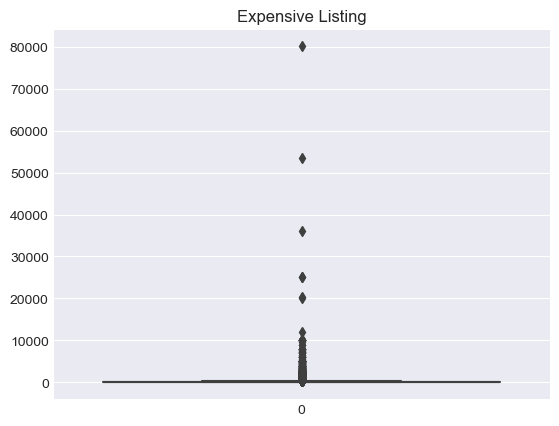

In [31]:
max_price = df_listing_cleaned['price'].max()
print(f"The most expensive Airbnb listing in London is at ${max_price}/night.")
sns.boxplot(df_listing_cleaned['price']).set(title= "Expensive Listing")

#### The most expensive Airbnb listing in London is at $80100/night.

## Analyze Neighbourhood Revenues wrt Room Type

### Problem: Which neighbourhood is generating maximum and minimum revenues in terms of private rooms,shared rooms and entire home?

In [ ]:
df_n_roomtype = df_listing_cleaned.groupby(['neighbourhood_cleansed','room_type']).agg({'price':'sum'})
df_n_roomtype 

In [32]:
df_n_roomtype = pd.pivot_table(df_n_roomtype, values='price', index=['neighbourhood_cleansed'], columns=['room_type'])

In [33]:
#Maximum revenue in Private Rooms
df_n_roomtype.sort_values('Private room', ascending = False).head(1)

room_type,Entire home/apt,Hotel room,Private room,Shared room
neighbourhood_cleansed,,,,
Westminster,2762568.0,19705.0,408766.0,12310.0


In [34]:
#Minimum revenue in Private Rooms
df_n_roomtype.sort_values('Private room', ascending = True).head(1)

room_type,Entire home/apt,Hotel room,Private room,Shared room
neighbourhood_cleansed,,,,
Sutton,23042.0,NaN,10880.0,300.0


In [35]:
#Maximum revenue in Entire home/apt
df_n_roomtype.sort_values('Entire home/apt', ascending = False).head(1)

room_type,Entire home/apt,Hotel room,Private room,Shared room
neighbourhood_cleansed,,,,
Westminster,2762568.0,19705.0,408766.0,12310.0


In [36]:
#Minimum revenue in Entire home/apt
df_n_roomtype.sort_values('Entire home/apt', ascending = True).head(1)

room_type,Entire home/apt,Hotel room,Private room,Shared room
neighbourhood_cleansed,,,,
Sutton,23042.0,NaN,10880.0,300.0


In [37]:
#Maximum revenue in Shared room
df_n_roomtype.sort_values('Shared room', ascending = False).head(1)

room_type,Entire home/apt,Hotel room,Private room,Shared room
neighbourhood_cleansed,,,,
Camden,970769.0,1983.0,183983.0,13595.0


In [38]:
#Minimum revenue in Shared room
df_n_roomtype.sort_values('Shared room', ascending = True).head(1)

room_type,Entire home/apt,Hotel room,Private room,Shared room
neighbourhood_cleansed,,,,
Havering,35578.0,NaN,10939.0,50.0


### Future Work: Perform Correlation Analysis.